## Set up

In [2]:
import os
base_dir = os.path.normpath(os.getcwd() + os.sep + os.pardir) 

In [3]:
# import requests # request img from web
# import shutil # save img locally
# from pathlib import Path
from PIL import Image
# import numpy as np
# import math
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms

import utilities

In [5]:
import sys
sys.path.append(f'{base_dir}/src/captum')
from captum import optim as optimviz

The tqdm package is required to use captum.optim's n_steps stop criteria with progress bar


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [46]:
preprocess = transforms.transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Load models

Models: 

https://github.com/pytorch/vision/blob/main/torchvision/models/alexnet.py

GoogleNet:

https://github.com/pytorch/captum/blob/optim-wip/captum/optim/models/_image/inception_v1.py line 11

torchvision googlenet:

https://github.com/pytorch/vision/blob/main/torchvision/models/googlenet.py

In [7]:
googlenet_torchhub = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True).to(device)
googlenet_torchhub.eval()

Using cache found in /home/lauraom/.cache/torch/hub/pytorch_vision_v0.10.0
/home/lauraom/anaconda3/envs/sw-interpretability/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lauraom/anaconda3/envs/sw-interpretability/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [8]:
googlenet_torchvision = torchvision.models.googlenet(pretrained=True).to(device)
googlenet_torchvision.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [9]:
googlenet_captum = optimviz.models._image.inception_v1.googlenet(pretrained=True).to(device)
googlenet_captum.eval()

InceptionV1(
  (conv1): Conv2dSame(3, 64, kernel_size=(7, 7), stride=(2, 2))
  (conv1_relu): RedirectedReluLayer()
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (local_response_norm1): LocalResponseNorm(11, alpha=0.0011, beta=0.5, k=2.0)
  (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv2_relu): RedirectedReluLayer()
  (conv3): Conv2dSame(64, 192, kernel_size=(3, 3), stride=(1, 1))
  (conv3_relu): RedirectedReluLayer()
  (local_response_norm2): LocalResponseNorm(11, alpha=0.0011, beta=0.5, k=2.0)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (mixed3a): InceptionModule(
    (conv_1x1): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
    (conv_3x3_reduce): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
    (conv_3x3_reduce_relu): RedirectedReluLayer()
    (conv_3x3): Conv2dSame(96, 128, kernel_size=(3, 3), stride=(1, 1))
    (conv_5x5_reduce): Conv2d(192, 16, kernel_size=(1, 1), str

## Extract activations

https://discuss.pytorch.org/t/how-to-register-forward-hooks-for-each-module/43347 
https://discuss.pytorch.org/t/how-can-l-load-my-best-model-as-a-feature-extractor-evaluator/17254

In [10]:
filename = f'{base_dir}/data/test-images/mixed4e55_imagenet/mixed4e55_imagenet_im_0.png'

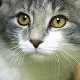

In [11]:
Image.open(filename)

In [12]:
input_image = Image.open(filename).convert('RGB') # since 'RGBA'

input_tensor = utilities.preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model 
# torch.Size([1, 3, 224, 224])

In [13]:
model = googlenet_torchhub
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)

### googlenet_torchhub

In [29]:
activation = {}
def get_activation(name, model):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [30]:
googlenet_torchhub.inception4e.branch1.conv.register_forward_hook(get_activation('inception4e.branch1.conv', googlenet_torchhub))
output = googlenet_torchhub(input_batch)
print(activation['inception4e.branch1.conv']) # torch.Size([1, 256, 14, 14])

tensor([[[[-5.8996e-01, -5.3918e-04,  8.7035e-02,  ..., -4.3434e-01,
            1.5759e-02, -6.0254e-01],
          [-4.7667e-02, -3.7851e-01, -3.6636e-01,  ..., -8.1495e-01,
           -7.7431e-01, -1.2299e+00],
          [ 2.7586e-01, -1.8074e-01, -1.1128e+00,  ..., -8.5017e-01,
           -3.8465e-01, -4.6790e-01],
          ...,
          [-6.8768e-01, -3.8408e-01, -7.8516e-01,  ..., -4.8249e-01,
           -2.8958e-02, -5.3655e-01],
          [-4.8412e-01, -5.7378e-02, -3.4981e-01,  ..., -3.5140e-01,
           -9.2419e-02, -3.7915e-01],
          [-4.4548e-01, -2.0120e-01, -4.0576e-01,  ..., -6.3764e-01,
           -5.5503e-01, -6.8821e-01]],

         [[-5.8648e-01, -4.4707e-01, -4.0711e-01,  ...,  5.2227e-02,
            1.9518e-01, -3.7338e-01],
          [-5.0108e-01, -9.9033e-01, -1.2046e+00,  ..., -3.4684e-01,
           -8.5838e-02, -2.2580e-01],
          [-1.9921e-01, -1.8962e+00, -2.1581e+00,  ..., -1.8155e+00,
           -1.1847e+00, -9.2382e-01],
          ...,
     

In [22]:
print(activation['inception4e.branch1.conv'][0].mean(2).mean(1)[55])
activation['inception4e.branch1.conv'][0].mean(2).mean(1) # torch.Size([256])

tensor(-1.0417)


tensor([-0.6159, -0.5180, -1.4558, -1.1922, -1.4980,  0.2562, -0.5135, -0.4904,
        -0.9703, -0.6608, -1.2949, -0.7500, -1.3681, -0.1363, -1.5643, -0.6122,
        -0.7456, -0.8824, -0.9252, -0.3892, -0.6584, -0.8279, -0.2775, -1.1982,
        -0.8967, -0.9242, -1.0389, -1.1528, -0.6703, -1.0948, -0.9780, -1.0041,
        -0.3507, -0.5458, -1.2385, -0.5098, -0.6917, -0.7085, -0.6416, -0.6745,
        -0.2973, -1.0830, -0.5421, -0.9236, -0.2561, -0.6813, -1.4557, -1.1798,
         0.1050, -1.1631,  0.1403, -1.4496,  0.2195, -0.6628, -0.8256, -1.0417,
        -0.3201, -0.3798, -0.9072, -0.0485, -0.8879,  0.1340, -0.7284, -1.8880,
        -1.0864, -1.1272, -0.3311, -0.8118, -0.8411, -0.6347, -1.2190, -0.6304,
        -0.4716, -0.6883, -0.7384, -1.2185, -0.7271, -1.4821, -0.9260, -1.4130,
        -0.9993, -0.0498, -1.0094, -0.1710, -0.4785, -0.3338, -0.5323, -0.8866,
        -0.2793, -0.9753, -0.4322, -0.7863, -0.9091, -1.4396, -0.1201, -0.3097,
        -1.1748, -0.7898, -1.1169, -0.83

### googlenet_torchvision

In [23]:
activation = {}
# def get_activation(name):
#     def hook(googlenet_torchvision, input, output):
#         activation[name] = output.detach()
#     return hook

In [24]:
googlenet_torchvision.inception4e.branch1.conv.register_forward_hook(get_activation('inception4e.branch1.conv', googlenet_torchvision))
output = googlenet_torchvision(input_batch)
print(activation['inception4e.branch1.conv'])

tensor([[[[-5.8996e-01, -5.3918e-04,  8.7035e-02,  ..., -4.3434e-01,
            1.5759e-02, -6.0254e-01],
          [-4.7667e-02, -3.7851e-01, -3.6636e-01,  ..., -8.1495e-01,
           -7.7431e-01, -1.2299e+00],
          [ 2.7586e-01, -1.8074e-01, -1.1128e+00,  ..., -8.5017e-01,
           -3.8465e-01, -4.6790e-01],
          ...,
          [-6.8768e-01, -3.8408e-01, -7.8516e-01,  ..., -4.8249e-01,
           -2.8958e-02, -5.3655e-01],
          [-4.8412e-01, -5.7378e-02, -3.4981e-01,  ..., -3.5140e-01,
           -9.2419e-02, -3.7915e-01],
          [-4.4548e-01, -2.0120e-01, -4.0576e-01,  ..., -6.3764e-01,
           -5.5503e-01, -6.8821e-01]],

         [[-5.8648e-01, -4.4707e-01, -4.0711e-01,  ...,  5.2227e-02,
            1.9518e-01, -3.7338e-01],
          [-5.0108e-01, -9.9033e-01, -1.2046e+00,  ..., -3.4684e-01,
           -8.5838e-02, -2.2580e-01],
          [-1.9921e-01, -1.8962e+00, -2.1581e+00,  ..., -1.8155e+00,
           -1.1847e+00, -9.2382e-01],
          ...,
     

In [25]:
print(activation['inception4e.branch1.conv'][0].mean(2).mean(1)[55])
activation['inception4e.branch1.conv'][0].mean(2).mean(1) 

tensor(-1.0417)


tensor([-0.6159, -0.5180, -1.4558, -1.1922, -1.4980,  0.2562, -0.5135, -0.4904,
        -0.9703, -0.6608, -1.2949, -0.7500, -1.3681, -0.1363, -1.5643, -0.6122,
        -0.7456, -0.8824, -0.9252, -0.3892, -0.6584, -0.8279, -0.2775, -1.1982,
        -0.8967, -0.9242, -1.0389, -1.1528, -0.6703, -1.0948, -0.9780, -1.0041,
        -0.3507, -0.5458, -1.2385, -0.5098, -0.6917, -0.7085, -0.6416, -0.6745,
        -0.2973, -1.0830, -0.5421, -0.9236, -0.2561, -0.6813, -1.4557, -1.1798,
         0.1050, -1.1631,  0.1403, -1.4496,  0.2195, -0.6628, -0.8256, -1.0417,
        -0.3201, -0.3798, -0.9072, -0.0485, -0.8879,  0.1340, -0.7284, -1.8880,
        -1.0864, -1.1272, -0.3311, -0.8118, -0.8411, -0.6347, -1.2190, -0.6304,
        -0.4716, -0.6883, -0.7384, -1.2185, -0.7271, -1.4821, -0.9260, -1.4130,
        -0.9993, -0.0498, -1.0094, -0.1710, -0.4785, -0.3338, -0.5323, -0.8866,
        -0.2793, -0.9753, -0.4322, -0.7863, -0.9091, -1.4396, -0.1201, -0.3097,
        -1.1748, -0.7898, -1.1169, -0.83

### googlenet_captum

In [26]:
activation = {}
# def get_activation(name):
#     def hook(googlenet_captum, input, output):
#         activation[name] = output.detach()
#     return hook

In [27]:
googlenet_captum.mixed4e.conv_1x1.register_forward_hook(get_activation('mixed4e.conv_1x1', googlenet_captum))
output = googlenet_captum(input_batch)
print(activation['mixed4e.conv_1x1'])

tensor([[[[-4.5330e+00, -7.4337e+00,  1.7682e+00,  ...,  8.8853e+00,
            1.4699e+01,  1.4988e+01],
          [-1.1282e+01, -1.1512e+01, -6.6918e+00,  ...,  2.4979e+00,
            2.1575e+01,  2.5458e+01],
          [-7.8115e+00, -6.3186e+00, -2.4946e+00,  ..., -9.7630e+00,
            5.6130e+00,  1.2689e+01],
          ...,
          [ 1.4245e+01,  2.5361e+01,  2.4913e+01,  ...,  3.6574e+01,
            2.0892e+01,  5.7895e+00],
          [ 8.8885e+00,  1.6009e+01,  1.7765e+01,  ...,  3.3915e+01,
            1.5632e+01,  6.3883e-01],
          [ 5.3367e+00,  6.1703e+00,  5.6122e+00,  ...,  2.2547e+01,
            6.2093e+00, -3.0197e+00]],

         [[-2.4860e+01, -1.8389e+01, -2.0910e+00,  ..., -2.8058e+00,
            4.5905e+01,  2.8094e+01],
          [-2.6425e+01, -6.9241e+00,  9.8489e+00,  ...,  2.0578e+00,
            3.9507e+01,  3.9089e+01],
          [-2.3425e+01, -2.4052e+00,  1.3045e+01,  ...,  2.8958e+00,
            1.0498e+01,  9.7913e+00],
          ...,
     

/mnt/c/Users/lauraa.omahony/Documents/~PhD_Stuff/1_Workspace/sw-interpretability/src/captum/captum/optim/models/_image/inception_v1.py:209: UserWarning: Model input has values outside of the range [0, 1].
  warn("Model input has values outside of the range [0, 1].")


In [28]:
print(activation['mixed4e.conv_1x1'][0].mean(2).mean(1)[55])
activation['mixed4e.conv_1x1'][0].mean(2).mean(1)

tensor(51.9002)


tensor([ 2.0670e+01,  2.6568e+00, -9.9606e+00,  1.1299e+01,  1.8719e+01,
        -2.4310e+01,  1.9512e+01, -7.9767e+00, -1.2247e+01, -1.2877e+01,
        -5.3039e+00, -4.2541e+00,  1.8439e+01, -1.0218e+00,  1.7505e+00,
         1.2673e+01, -7.5612e+00, -1.0299e+01, -2.9500e+01, -2.1995e+01,
        -3.3613e-01, -6.9404e+00, -1.6604e+01, -2.6674e+01,  3.0831e+01,
         2.4460e+01, -1.3770e+01,  2.0567e+01, -1.6080e+01, -6.4652e+00,
         6.5528e+00, -7.5050e+00, -2.7825e+01, -3.7578e+00, -1.4884e+01,
         1.2554e+01,  1.3543e+01, -1.5090e+01,  2.8769e+00, -2.0289e+01,
        -1.1649e+01, -2.7810e+00,  1.2036e+02, -4.8256e+00,  1.1198e+00,
        -1.1509e+01, -1.2520e+01, -7.5820e+00,  7.8733e+00, -2.1391e+01,
        -1.2434e+01, -1.4221e+01, -3.3297e+01, -2.8674e+01, -1.0916e+01,
         5.1900e+01, -1.3952e+00, -5.5183e+00, -3.0610e+00, -4.1305e+01,
         3.7013e+01, -1.1625e+01, -4.0018e+00,  1.6728e+00, -9.9210e+00,
        -1.3721e+01,  2.0084e+00,  7.2188e+00, -1.3

In [42]:
model.inception4e.branch1.conv

Conv2d(528, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)

## Analyse activations and similarity

In [52]:
activations_cat_dict = {}
activations_car_dict = {}
activations_cat_avg_dict = {}
activations_car_avg_dict = {}

activations_cat_avg_dot_dict = {}
activations_car_avg_dot_dict = {}
activations_cat_car_avg_dot_dict = {}

activations_cat_avg_sim_dict = {}
activations_car_avg_sim_dict = {}
activations_cat_car_avg_sim_dict = {}

### Extract activations, calculate averages, dot products

In [53]:
# Change layer name here and run
layer = 'mixed4e.conv_1x1'

In [54]:
# activation = {}
# def get_activation(name):
#     def hook(googlenet_captum, input, output):
#         activation[name] = output.detach()
#     return hook

In [55]:
activations_cat = torch.empty(0,256,14,14)
activations_car = torch.empty(0,256,14,14)
directory_cat = f'{base_dir}/data/test-images/cat'
directory_car = f'{base_dir}/data/test-images/car'

for file in os.listdir(directory_cat): # os.listdir(directory)
    activation = {}
    input_image = Image.open(directory_cat+'/'+file).convert('RGB') # since 'RGBA'
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    googlenet_captum.mixed4e.conv_1x1.register_forward_hook(get_activation(layer, googlenet_captum))
    output = googlenet_captum(input_batch)
    activations_cat = torch.cat((activations_cat,activation[layer]))

for file in os.listdir(directory_car):
    activation = {}
    input_image = Image.open(directory_car+'/'+file).convert('RGB') # since 'RGBA'
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    googlenet_captum.mixed4e.conv_1x1.register_forward_hook(get_activation(layer, googlenet_captum))
    output = googlenet_captum(input_batch)
    activations_car = torch.cat((activations_car,activation[layer]))

/mnt/c/Users/lauraa.omahony/Documents/~PhD_Stuff/1_Workspace/sw-interpretability/src/captum/captum/optim/models/_image/inception_v1.py:209: UserWarning: Model input has values outside of the range [0, 1].
  warn("Model input has values outside of the range [0, 1].")


In [57]:
activations_cat_avg = activations_cat.mean(3).mean(2) 
activations_car_avg = activations_car.mean(3).mean(2) 

In [58]:
# np.dot(activations_car_avg[0], activations_car_avg[0])/(np.linalg.norm(activations_car_avg[0])*np.linalg.norm(activations_car_avg[0])) 

In [59]:
activations_cat_avg_dot = np.empty([len(activations_cat_avg),len(activations_cat_avg)])
activations_cat_avg_sim = np.empty([len(activations_cat_avg),len(activations_cat_avg)])
for i in range(len(activations_cat_avg)):
    for j in range(len(activations_cat_avg)):
        activations_cat_avg_dot[i,j] = np.dot(activations_cat_avg[i], activations_cat_avg[j])
        activations_cat_avg_sim[i,j] = activations_cat_avg_dot[i,j]/(np.linalg.norm(activations_cat_avg[i])*np.linalg.norm(activations_cat_avg[j])) 
        
activations_car_avg_dot = np.empty([len(activations_car_avg),len(activations_car_avg)])
activations_car_avg_sim = np.empty([len(activations_car_avg),len(activations_car_avg)])
for i in range(len(activations_car_avg)):
    for j in range(len(activations_car_avg)):
        activations_car_avg_dot[i,j] = np.dot(activations_car_avg[i], activations_car_avg[j])
        activations_car_avg_sim[i,j] = activations_car_avg_dot[i,j]/(np.linalg.norm(activations_car_avg[i])*np.linalg.norm(activations_car_avg[j])) 
        
activations_cat_car_avg_dot = np.empty([len(activations_cat_avg),len(activations_car_avg)])
activations_cat_car_avg_sim = np.empty([len(activations_cat_avg),len(activations_car_avg)])
for i in range(len(activations_cat_avg)):
    for j in range(len(activations_car_avg)):
        activations_cat_car_avg_dot[i,j] = np.dot(activations_cat_avg[i], activations_car_avg[j])
        activations_cat_car_avg_sim[i,j] = activations_cat_car_avg_dot[i,j]/(np.linalg.norm(activations_cat_avg[i])*np.linalg.norm(activations_car_avg[j])) 


### Save

In [60]:
activations_cat_dict[layer] = activations_cat
activations_car_dict[layer] = activations_car
activations_cat_avg_dict[layer] = activations_cat_avg
activations_car_avg_dict[layer] = activations_car_avg

activations_cat_avg_dot_dict[layer] = activations_cat_avg_dot
activations_car_avg_dot_dict[layer] = activations_car_avg_dot
activations_cat_car_avg_dot_dict[layer] = activations_cat_car_avg_dot

activations_cat_avg_sim_dict[layer] = activations_cat_avg_sim
activations_car_avg_sim_dict[layer] = activations_car_avg_sim
activations_cat_car_avg_sim_dict[layer] = activations_cat_car_avg_sim

In [61]:
activations_cat_dict

{'mixed4e.conv_1x1': tensor([[[[-4.5330e+00, -7.4337e+00,  1.7682e+00,  ...,  8.8853e+00,
             1.4699e+01,  1.4988e+01],
           [-1.1282e+01, -1.1512e+01, -6.6918e+00,  ...,  2.4979e+00,
             2.1575e+01,  2.5458e+01],
           [-7.8115e+00, -6.3186e+00, -2.4946e+00,  ..., -9.7630e+00,
             5.6130e+00,  1.2689e+01],
           ...,
           [ 1.4245e+01,  2.5361e+01,  2.4913e+01,  ...,  3.6574e+01,
             2.0892e+01,  5.7895e+00],
           [ 8.8885e+00,  1.6009e+01,  1.7765e+01,  ...,  3.3915e+01,
             1.5632e+01,  6.3883e-01],
           [ 5.3367e+00,  6.1703e+00,  5.6122e+00,  ...,  2.2547e+01,
             6.2093e+00, -3.0197e+00]],
 
          [[-2.4860e+01, -1.8389e+01, -2.0910e+00,  ..., -2.8058e+00,
             4.5905e+01,  2.8094e+01],
           [-2.6425e+01, -6.9241e+00,  9.8489e+00,  ...,  2.0578e+00,
             3.9507e+01,  3.9089e+01],
           [-2.3425e+01, -2.4052e+00,  1.3045e+01,  ...,  2.8958e+00,
             1.0498

### Analyse activations from some layer

In [ ]:
layer = 'mixed4e.conv_1x1'

In [ ]:
print(activations_car_dict[layer][0].mean(2).mean(1)[55])
print(activations_car_dict[layer][1].mean(2).mean(1)[55])
print(activations_car_dict[layer][-1].mean(2).mean(1)[55])
activation[layer][0].mean(2).mean(1)

Outputs 256 14x14 feature maps. 
How to visualise/analyse this shape? 
Create loop and average?? Look at unit 55. 

In [ ]:
# car hood: imagenet 81, flickr 61, 76, 81, 98

In [ ]:
# activations_cat_dict['mixed4e.conv_1x1'].shape # torch.Size([17, 256, 14, 14])
# activations_car_dict['mixed4e.conv_1x1'].shape # torch.Size([5, 256, 14, 14])

In [ ]:
# len(activations_cat_dict['mixed4e.conv_1x1']) # 17
# len(activations_car_dict['mixed4e.conv_1x1']) # 5
# activations_cat_avg_dict['mixed4e.conv_1x1'].shape # torch.Size([17, 256])
# activations_car_avg_dict['mixed4e.conv_1x1'].shape # torch.Size([5, 256])

In [ ]:
activations_cat_avg_dict[layer][0]

In [ ]:
print(activations_cat_dict[layer][0].mean(2).mean(1)[55])
print(activations_cat_dict[layer][1].mean(2).mean(1)[55])
print(activations_cat_dict[layer][-1].mean(2).mean(1)[55])

In [ ]:
activations_car_avg_dict[layer][2]

In [ ]:
plt.plot(activations_cat_avg_dict[layer][0]) # 42 peak

In [ ]:
plt.plot(activations_car_avg_dict[layer][0]) # 42 peak

### Cosine similarities

In [ ]:
cat = [f"cat{i}" for i in range(len(activations_cat_avg_dot_dict[layer]))]
car = [f"car{i}" for i in range(len(activations_car_avg_dot_dict[layer]))]

min_dot = min(np.amin(activations_cat_avg_dot_dict[layer]), np.amin(activations_car_avg_dot_dict[layer]), np.amin(activations_cat_car_avg_dot_dict[layer])) 
max_dot = max(np.amax(activations_cat_avg_dot_dict[layer]), np.amax(activations_car_avg_dot_dict[layer]), np.amax(activations_cat_car_avg_dot_dict[layer])) 

fig, axs = plt.subplots(3,1,figsize=(6, 12))

im1 = axs[0].imshow(activations_cat_avg_dot_dict[layer], cmap='viridis', interpolation='nearest', vmin=min_dot, vmax=max_dot)
axs[0].set_xticks(np.arange(len(activations_cat_avg_dot_dict[layer])), labels=cat)
axs[0].set_yticks(np.arange(len(activations_cat_avg_dot_dict[layer])), labels=cat)
axs[0].set_title("activations_cat_avg_dot")

im2 = axs[1].imshow(activations_car_avg_dot_dict[layer], cmap='viridis', interpolation='nearest', vmin=min_dot, vmax=max_dot)
axs[1].set_xticks(np.arange(len(activations_car_avg_dot_dict[layer])), labels=car)
axs[1].set_yticks(np.arange(len(activations_car_avg_dot_dict[layer])), labels=car)
axs[1].set_title("activations_car_avg_dot")
for i in range(len(activations_car_avg_dot_dict[layer])):
    for j in range(len(activations_car_avg_dot_dict[layer])):
        text = axs[1].text(j, i, activations_car_avg_dot_dict[layer][i, j]//1000,
                       ha="center", va="center", color="w")
        
im2 = axs[2].imshow(activations_cat_car_avg_dot_dict[layer], cmap='viridis', interpolation='nearest', vmin=min_dot, vmax=max_dot)
axs[2].set_xticks(np.arange(len(activations_car_avg_dot_dict[layer])), labels=car)
axs[2].set_yticks(np.arange(len(activations_cat_avg_dot_dict[layer])), labels=cat)
axs[2].set_title("activations_cat_car_avg_dot")

plt.subplots_adjust(right=0.8)
cbar_ax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(mappable=(im1), cax=cbar_ax)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])

plt.show()

In [ ]:
cat = [f"cat{i}" for i in range(len(activations_cat_avg_sim_dict[layer]))]
car = [f"car{i}" for i in range(len(activations_car_avg_sim_dict[layer]))]

min_sim = 0
max_sim = 1

fig, axs = plt.subplots(3,1,figsize=(6, 12))

im1 = axs[0].imshow(activations_cat_avg_sim_dict[layer], cmap='viridis', interpolation='nearest', vmin=min_sim, vmax=max_sim) 
axs[0].set_xticks(np.arange(len(activations_cat_avg_sim_dict[layer])), labels=cat)
axs[0].set_yticks(np.arange(len(activations_cat_avg_sim_dict[layer])), labels=cat)
axs[0].set_title("activations_cat_avg_sim")

im2 = axs[1].imshow(activations_car_avg_sim_dict[layer], cmap='viridis', interpolation='nearest', vmin=min_sim, vmax=max_sim) 
axs[1].set_xticks(np.arange(len(activations_car_avg_sim_dict[layer])), labels=car)
axs[1].set_yticks(np.arange(len(activations_car_avg_sim_dict[layer])), labels=car)
axs[1].set_title("activations_car_avg_sim")
for i in range(len(activations_car_avg_sim_dict[layer])):
    for j in range(len(activations_car_avg_sim_dict[layer])):
        text = axs[1].text(j, i, round(activations_car_avg_sim_dict[layer][i, j],2),
                       ha="center", va="center") # , color="w"
        
im2 = axs[2].imshow(activations_cat_car_avg_sim_dict[layer], cmap='viridis', interpolation='nearest', vmin=min_sim, vmax=max_sim) 
axs[2].set_xticks(np.arange(len(activations_car_avg_sim_dict[layer])), labels=car)
axs[2].set_yticks(np.arange(len(activations_cat_avg_sim_dict[layer])), labels=cat)
axs[2].set_title("activations_cat_car_avg_sim")

plt.subplots_adjust(right=0.8)
cbar_ax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(mappable=(im1), cax=cbar_ax)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])

plt.show()

## Other

Another model...

In [ ]:
activations_cat = torch.empty(0,256,14,14)
activations_car = torch.empty(0,256,14,14)
directory_cat = f'{base_dir}/data/test-images/cat'
directory_car = f'{base_dir}/data/test-images/car'

for file in os.listdir(directory_cat): # os.listdir(directory)
    activation = {}
    input_image = Image.open(directory_cat+'/'+file).convert('RGB') # since 'RGBA'
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    googlenet_torchvision.inception4e.branch1.conv.register_forward_hook(get_activation(layer, googlenet_torchvision))
    output = googlenet_torchvision(input_batch)
    activations_cat = torch.cat((activations_cat,activation[layer]))

for file in os.listdir(directory_car):
    activation = {}
    input_image = Image.open(directory_car+'/'+file).convert('RGB') # since 'RGBA'
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)

    googlenet_torchvision.inception4e.branch1.conv.register_forward_hook(get_activation(layer, googlenet_torchvision))
    output = googlenet_torchvision(input_batch)
    activations_car = torch.cat((activations_car,activation[layer]))